В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в соревновании по сентимент-анализу :

https://www.kaggle.com/c/product-reviews-sentiment-analysis/


В качестве метрики качества используется accuracy , не менее 85%.

In [433]:
import pandas as pd
import bs4
import requests
import string
from string import punctuation
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [453]:
def prepare_test_data():
    with open("test.csv", 'rb') as f:
        reader = f.read()
        parser = bs4.BeautifulSoup(reader, 'lxml')
        y = parser.findAll('review')
        test_text = [i.text for i in y]
        
    return pd.DataFrame(test_text,columns=['review'])

In [454]:
test_data = prepare_test_data()

In [439]:
test_data.head()

,review
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментариях\nК сожалению, факт по..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."


In [440]:
test_data.shape

(100, 1)

**Соберем данные для трейна**

маркет не смог. заюзаю мейл
https://hi-tech.mail.ru/mobile-catalog/?sort=page&page - всего 74 страницы. пройдусь ка каждой и заберу ссылки на товары в список. пригодятся для второго этапа(парсинга текста)

In [276]:
def link (num=75): 
    '''собираем линки по каждома айтиму'''
    links = []
    for i in range(1,num):
        req = requests.get('https://hi-tech.mail.ru/mobile-catalog/?sort=price&sort_order=asc&page=' + str(i))
        if req.status_code != 200:
            print('БАН')
            break 
        parser = bs4.BeautifulSoup(req.text, 'html')
        page = parser.find_all('a', {'class' : 'p-catalog-card__link link-holder'})
        for item in page:
            links.append(item.get('href'))
    return links
    

In [277]:
links = link()

In [334]:
def load_train (): 
    '''собираем текст по каждому айтиму, по которому есть отзывы'''
    for link in links:
        req = requests.get('https://hi-tech.mail.ru' + link)
        if req.status_code != 200:
            print('БАН')
            break 
        parser = bs4.BeautifulSoup(req.text, 'html')
        texts = parser.findAll('span', attrs={'class':'card__text'})
        for atributs in texts:
            if parser.find('span', {'class' : 'label js-review-list__title-label'}) and atributs.find('span', {'class' : "text text_bold_medium margin_left_10"}):
                star = atributs.find('span', {'class' : "text text_bold_medium margin_left_10"}).text or '0'
                text = atributs.find('div', {'class' : "p-model-review__text"}).findAll('span', attrs={'class':'text'})
                itog = star + ';'
                for i in text:
                    itog += i.text + ';'
                    itog = itog.replace('\n','')
                    itog = itog.replace('\r','')
                with open ('review1.csv', mode = 'a', encoding='utf-8') as file:
                    file.write(itog + '\n')
                
               

In [335]:
load_train()

**Загрузим данные и обучим модель**

In [403]:
def load (number_of_del = 4):
    "загружает файл и удаляем смещенные столбцы из парсинга"
    data = []
    with open('review1.csv', encoding='utf-8') as f:
        for line in f:
            data.append(line.rstrip().split(';'))
    for i in data:
        del i[number_of_del:]   

    return data
        

In [404]:
data = load()

In [402]:
negfeats, posfeats = [], []

In [407]:
for i in data:
    if len(i) == 4:
        if int(i[0]) <= 2:
            negfeats.append(i[3])
        elif int(i[0]) >= 4:
            posfeats.append(i[3])
    
        negfeats.append(i[2])
        posfeats.append(i[1])
    

In [410]:
len(posfeats)


7218

In [411]:
len(negfeats)

4348

In [412]:
texts = negfeats + posfeats[:4348]

In [430]:
labels = [0] * len(negfeats) + [1] * len(posfeats[:4348])

In [416]:
def delete_punctuation(line):
    translation_table = str.maketrans('', '', string.punctuation)
    return line.translate(translation_table).lower()

In [417]:
def format_str(line):
    word_list = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in word_list]
    stroka = delete_punctuation(' '.join(words))
    words = [word.strip() for word in stroka.split()]
    return ' '.join(words)

In [424]:
lemmatizer = WordNetLemmatizer()
for i, line in enumerate(texts):
       texts[i] = format_str(line)

In [431]:
X_train, X_test, y_train, y_test = train_test_split(texts,labels, test_size=0.1, random_state=123)

**обучим векторайзер**

In [435]:
vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer_for_cross = vectorizer.fit(X_train)
vector = vectorizer.fit_transform(X_train)
cross_val_score(LogisticRegression(random_state=122), vector, y_train,scoring='accuracy', cv=5).mean()

0.9600044067423157

**норм. обработаем тест и на банкет**

In [441]:
for i, line in enumerate(test_data.review):
    test_data.review[i] = format_str(line)

In [444]:
pipeline = Pipeline([(' CountVectorizer', CountVectorizer(ngram_range=(1,2))), 
                          ('log_reg', LogisticRegression())])

In [445]:
pipeline.fit(texts, labels)

Pipeline(memory=None,
         steps=[(' CountVectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
          

In [462]:
kaggle = pd.DataFrame()

In [476]:
kaggle['pred'] = pipeline.predict(test_data['review'])

In [477]:
kaggle['y'] = ['pos' if x==1 else 'neg' for x in kaggle.pred]
kaggle['Id'] = range(100)

In [478]:
kaggle[['Id','y']].to_csv('kaggle_sentiment.csv', index = False)

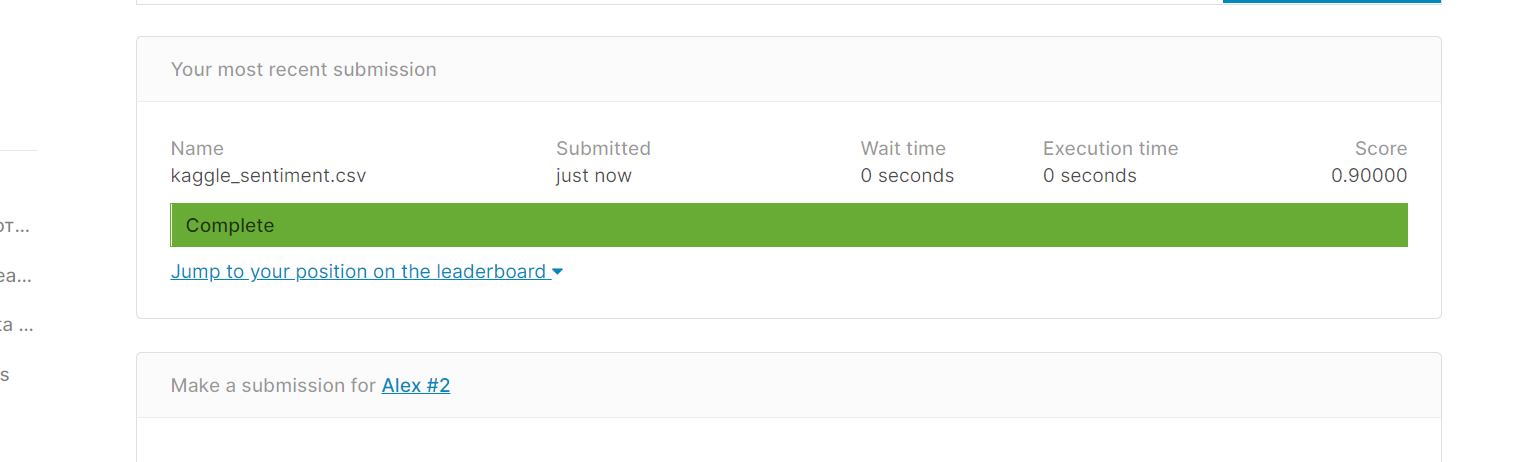

In [479]:
from IPython.display import Image
Image("kaggle.PNG")